In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
import seaborn as sns

In [64]:
sns.set_palette("colorblind")
%config InlineBackend.figure_format = "retina"

In [65]:
agents = ["LRKF", "FLoRES", "OGD", "LoFi"]

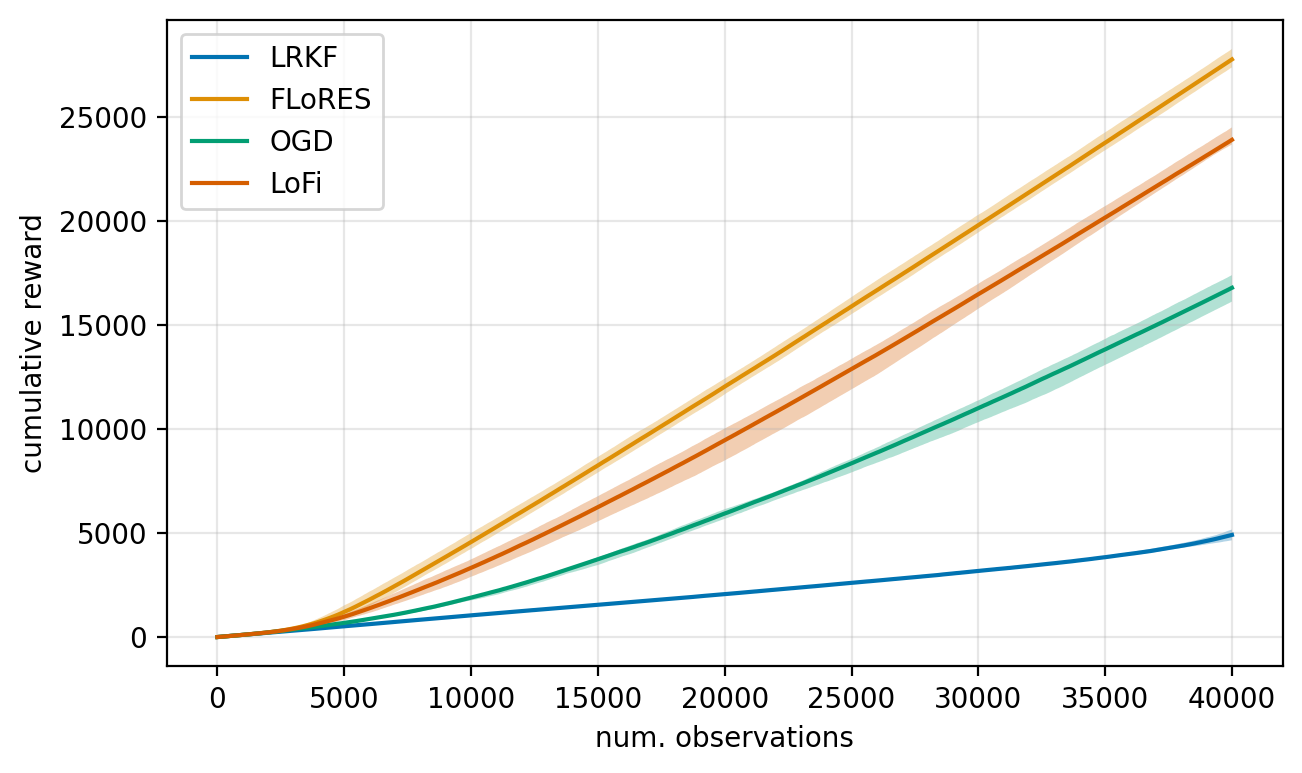

In [66]:
fig, ax = plt.subplots(figsize=(7.2, 4.2))

for agent in agents:
    agent_path = f"./output/{agent}_eps_5.pkl"
    
    res = pd.read_pickle(agent_path)
    
    rewards = pd.DataFrame(res["rewards"].T)
    
    median = rewards.cumsum().mean(axis=1)
    lbound = rewards.cumsum().quantile(0.25, axis=1)
    ubound = rewards.cumsum().quantile(0.75, axis=1)
    
    median.plot(label=agent)
    plt.fill_between(median.index, lbound, ubound, alpha=0.3)
plt.legend()
plt.xlabel("num. observations")
plt.ylabel("cumulative reward")
plt.grid(alpha=0.3)
plt.savefig("../figures/mnist-bandit-reward.png", dpi=300, bbox_inches="tight")